In [1]:
import os, glob
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
from haloflow import data as D

In [3]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [4]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [6]:
dat_dir = '/scratch/gpfs/chhahn/haloflow'

In [7]:
def read_best_models(study_name): 
    fevents = glob.glob(os.path.join(dat_dir, 'nde/%s/*/events*' % study_name))

    events, best_valid = [], []
    for fevent in fevents: 
        ea = EventAccumulator(fevent)
        ea.Reload()

        try: 
            best_valid.append(ea.Scalars('best_validation_log_prob')[0].value)
            events.append(fevent)
        except: 
            pass #print(fevent)
    best_valid = np.array(best_valid)

    print('%i models trained' % np.max([int(os.path.dirname(event).split('.')[-1]) for event in events]))
    
    i_models = [int(os.path.dirname(events[i]).split('.')[-1]) for i in np.argsort(best_valid)[-5:][::-1]]
    print(i_models) 
    
    qphis = []
    for i_model in i_models: 
        fqphi = os.path.join(dat_dir, 'nde/%s/%s.%i.pt' % (study_name, study_name, i_model))
        qphi = torch.load(fqphi, map_location=device)
        qphis.append(qphi)
    return qphis

In [63]:
qphis = read_best_models('mags.maf')

29 models trained
[21, 19, 0, 2, 4]


In [64]:
y_test, x_test = D.get_subhalos('test', 'mags', snapshot=91)

In [65]:
n_sample = 10000

ranks, y_nde = [], []
for i in trange(y_test.shape[0]): 
    y_samp = []
    for qphi in qphis: 
        _samp = qphi.sample((int(n_sample/len(qphis)),),
                           x=torch.tensor(x_test[i], dtype=torch.float32).to(device), 
                           show_progress_bars=False)

        y_samp.append(_samp.detach().cpu().numpy())
    ranks.append(np.mean(np.array(y_samp).flatten() < y_test[i]))
    y_nde.append(np.array(y_samp).flatten())
ranks = np.array(ranks)
y_nde = np.array(y_nde)

  0%|          | 0/500 [00:00<?, ?it/s]

[]

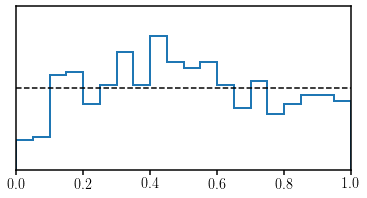

In [66]:
fig = plt.figure(figsize=(6,3))
sub = fig.add_subplot(111)
_ = sub.hist(ranks, range=(0., 1), bins=20, histtype='step', density=True, linewidth=2)

sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.set_xlim(0., 1.)
sub.set_ylim(0., 2.)
sub.set_yticks([])

(10.5, 15.0)

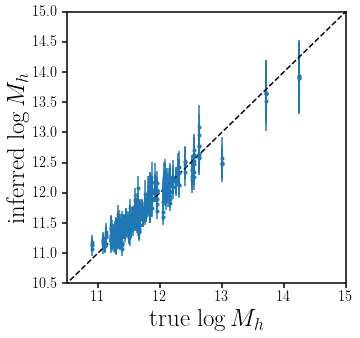

In [67]:
q1, q2, q3 = np.quantile(y_nde, (0.16, 0.5, 0.84), axis=1)

fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.errorbar(y_test, q2, yerr=[q2-q1, q3-q2], fmt='.C0')
sub.plot([10., 15], [10., 15], c='k', ls='--')
sub.set_xlabel(r'true $\log M_h$', fontsize=25)
sub.set_xlim(10.5, 15.)
sub.set_ylabel(r'inferred $\log M_h$', fontsize=25)
sub.set_ylim(10.5, 15.)